<a href="https://colab.research.google.com/github/gilhotraapoorva/DF/blob/main/MESO4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle (2).json to kaggle (2).json


{'kaggle (2).json': b'{"username":"apoorvaaaaaa","key":"d66784d4565981100258ecf8a750e6a2"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list


ref                                                   title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
sudarshan24byte/online-food-dataset                   Online Food Dataset                                  3KB  2024-03-02 18:50:30          11825        231  0.9411765        
syedanwarafridi/vehicle-sales-data                    Vehicle Sales Data                                  19MB  2024-02-21 20:16:17          20606        357  1.0              
bhavikjikadara/student-study-performance              Student Study Performance                            9KB  2024-03-07 06:14:09           6365         97  1.0              
julianoorlandi/spotify-top-songs-and-audio-features   Spotify Top Songs and Audio Features               526KB  202

In [ ]:
!kaggle competitions download -c deepfake-detection-challenge

100% 4.13G/4.13G [02:40<00:00, 36.7MB/s]
100% 4.13G/4.13G [02:41<00:00, 27.6MB/s]


In [ ]:
! mkdir train

In [ ]:
! unzip deepfake-detection-challenge.zip -d train

Archive:  deepfake-detection-challenge.zip
  inflating: train/sample_submission.csv  
  inflating: train/test_videos/aassnaulhq.mp4  
  inflating: train/test_videos/aayfryxljh.mp4  
  inflating: train/test_videos/acazlolrpz.mp4  
  inflating: train/test_videos/adohdulfwb.mp4  
  inflating: train/test_videos/ahjnxtiamx.mp4  
  inflating: train/test_videos/ajiyrjfyzp.mp4  
  inflating: train/test_videos/aktnlyqpah.mp4  
  inflating: train/test_videos/alrtntfxtd.mp4  
  inflating: train/test_videos/aomqqjipcp.mp4  
  inflating: train/test_videos/apedduehoy.mp4  
  inflating: train/test_videos/apvzjkvnwn.mp4  
  inflating: train/test_videos/aqrsylrzgi.mp4  
  inflating: train/test_videos/axfhbpkdlc.mp4  
  inflating: train/test_videos/ayipraspbn.mp4  
  inflating: train/test_videos/bcbqxhziqz.mp4  
  inflating: train/test_videos/bcvheslzrq.mp4  
  inflating: train/test_videos/bdshuoldwx.mp4  
  inflating: train/test_videos/bfdopzvxbi.mp4  
  inflating: train/test_videos/bfjsthfhbd.mp4  
  

In [ ]:
import os

In [ ]:
TRAIN_DIR = '/content/train/train_sample_videos/'
TMP_DIR = '/content/train/tmp/'
ZIP_NAME = 'dfdc_train_faces_sample.zip'
METADATA_PATH = TRAIN_DIR + 'metadata.json'

SCALE = 0.25
N_FRAMES = None

In [ ]:
!pip install facenet-pytorch > /dev/null 2>&1
!apt install zip > /dev/null 2>&1

In [ ]:
import os
import glob
import json
import torch
import cv2
from PIL import Image
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from facenet_pytorch import MTCNN

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f'Running on device: {device}')

Running on device: cpu


In [ ]:
class FaceExtractor:
    def __init__(self, detector, n_frames=None, resize=None):
        """
        Parameters:
            n_frames {int} -- Total number of frames to load. These will be evenly spaced
                throughout the video. If not specified (i.e., None), all frames will be loaded.
                (default: {None})
            resize {float} -- Fraction by which to resize frames from original prior to face
                detection. A value less than 1 results in downsampling and a value greater than
                1 result in upsampling. (default: {None})
        """
        self.detector = detector
        self.n_frames = n_frames
        self.resize = resize

    def __call__(self, filename, save_dir):
        """Load frames from an MP4 video, detect faces and save the results.

        Parameters:
            filename {str} -- Path to video.
            save_dir {str} -- The directory where results are saved.
        """

        # Create video reader and find length
        v_cap = cv2.VideoCapture(filename)
        v_len = int(v_cap.get(cv2.CAP_PROP_FRAME_COUNT))

        # Pick 'n_frames' evenly spaced frames to sample
        if self.n_frames is None:
            sample = np.arange(0, v_len)
        else:
            sample = np.linspace(0, v_len - 1, self.n_frames).astype(int)

        # Loop through frames
        for j in range(v_len):
            success = v_cap.grab()
            if j in sample:
                # Load frame
                success, frame = v_cap.retrieve()
                if not success:
                    continue
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frame = Image.fromarray(frame)

                # Resize frame to desired size
                if self.resize is not None:
                    frame = frame.resize([int(d * self.resize) for d in frame.size])

                save_path = os.path.join(save_dir, f'{j}.png')

                self.detector([frame], save_path=save_path)

        v_cap.release()

In [ ]:
with open(METADATA_PATH, 'r') as f:
    metadata = json.load(f)


In [ ]:
train_df = pd.DataFrame(
    [
        (video_file, metadata[video_file]['label'], metadata[video_file]['split'], metadata[video_file]['original'] if 'original' in metadata[video_file].keys() else '')
        for video_file in metadata.keys()
    ],
    columns=['filename', 'label', 'split', 'original']
)

train_df.head()

,filename,label,split,original
0,aagfhgtpmv.mp4,FAKE,train,vudstovrck.mp4
1,aapnvogymq.mp4,FAKE,train,jdubbvfswz.mp4
2,abarnvbtwb.mp4,REAL,train,None
3,abofeumbvv.mp4,FAKE,train,atvmxvwyns.mp4
4,abqwwspghj.mp4,FAKE,train,qzimuostzz.mp4


In [ ]:
face_detector = MTCNN(margin=14, keep_all=True, factor=0.5, device=device).eval()

In [ ]:
face_extractor = FaceExtractor(detector=face_detector, n_frames=N_FRAMES, resize=SCALE)

In [ ]:

all_train_videos = glob.glob(os.path.join(TRAIN_DIR, '*.mp4'))

In [ ]:
!mkdir -p $TMP_DIR


In [ ]:
import random
num_videos_to_process = 15
selected_videos = random.sample(all_train_videos, num_videos_to_process)

with torch.no_grad():
    for path in tqdm(selected_videos, desc="Processing videos"):
        file_name = os.path.basename(path)
        save_dir = os.path.join(TMP_DIR, os.path.splitext(file_name)[0])

        if not os.path.exists(save_dir):
            os.makedirs(save_dir)

        # Detect all faces appear in the video and save them.
        face_extractor(path, save_dir)

Processing videos:   0%|          | 0/15 [00:00<?, ?it/s]

In [ ]:
cd $TMP_DIR


/content/train/tmp


In [ ]:
train_df.to_csv('metadata.csv', index=False)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Reshape, Concatenate, LeakyReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

In [ ]:
image_dimensions = {'height':256,'width':256,'channels':3}

In [ ]:
class Classifier:
  def __init__():
    self.model = 0

  def predict(self,x):
    return self.model.predict(x)

  def fit(self,x,y):
    return self.model.train_on_batch(x,y)

  def get_accuracy(self,x,y):
    return self.model.test_on_batch(x,y)

  def load(self,path):
    self.model.load_weights(path)

# **MODEL-MESO4**

In [ ]:
class Meso4(Classifier):
  def __init__(self,learning_rate = 0.001):
    self.model = self.init_model()
    optimizer = Adam(lr = learning_rate)
    self.model.compile(optimizer = optimizer, loss = 'mean_squared_error',metrics = ['accuracy'])
  def init_model(self):
      x = Input(shape = (image_dimensions['height'],
                          image_dimensions['width'],
                          image_dimensions['channels']))

      x1 = Conv2D(8, (3, 3), padding='same', activation = 'relu')(x)
      x1 = BatchNormalization()(x1)
      x1 = MaxPooling2D(pool_size=(2, 2), padding='same')(x1)

      x2 = Conv2D(8, (5, 5), padding='same', activation = 'relu')(x1)
      x2 = BatchNormalization()(x2)
      x2 = MaxPooling2D(pool_size=(2, 2), padding='same')(x2)

      x3 = Conv2D(16, (5, 5), padding='same', activation = 'relu')(x2)
      x3 = BatchNormalization()(x3)
      x3 = MaxPooling2D(pool_size=(2, 2), padding='same')(x3)

      x4 = Conv2D(16, (5, 5), padding='same', activation = 'relu')(x3)
      x4 = BatchNormalization()(x4)
      x4 = MaxPooling2D(pool_size=(4, 4), padding='same')(x4)

      y = Flatten()(x4)
      y = Dropout(0.5)(y)
      y = Dense(16)(y)
      y = LeakyReLU(alpha=0.1)(y)
      y = Dropout(0.5)(y)
      y = Dense(1, activation = 'sigmoid')(y)

      return Model(inputs = x, outputs = y)

In [ ]:
import tensorflow as tf

In [ ]:
data_dir = "/content/train/tmp"  # Assuming your data is in /content/tmp
test_size = 0.25  # Adjust this value for your desired test set size
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=test_size,
    subset="training",
    seed=42,  # Set a seed for reproducibility (optional)
    shuffle=True
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=test_size,
    subset="validation",
    seed=42  # Same seed for consistent split
)

for images, labels in train_ds:
  x_train = images.numpy()
  y_train = labels.numpy()
for images, labels in test_ds:
  x_test = images.numpy()
  y_test = labels.numpy()


Found 4522 files belonging to 17 classes.
Using 3392 files for training.
Found 4522 files belonging to 17 classes.
Using 1130 files for validation.


In [ ]:
from tensorflow.keras.datasets import cifar10  # Example dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load and preprocess data (replace with your data loading)
# (x_train, y_train), (x_test, y_test) = tmp.load_data()

# datagen = ImageDataGenerator(rescale=1./255)
# # datagen.fit(x_train)
# datagen = ImageDataGenerator(rotation_range=20, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
# Create and train the model
model = Meso4(learning_rate=0.1)

model.model.compile(optimizer='adam', loss='binary_crossentropy')
# from tensorflow.keras.losses import CategoricalCrossentropy
# model.model.compile(optimizer='sgd', loss=CategoricalCrossentropy())
model.model.fit(x_train, y_train, batch_size=32, epochs=10,
          validation_data=(x_test, y_test))

# Define the evaluate_model function to calculate metrics (implementation details omitted)
def evaluate_model(y_true, y_pred):
    # ... (code to calculate accuracy, precision, and confusion matrix)
    # ...
  # 2. Calculate accuracy (assuming binary classification)
  y_pred = (y_pred > 0.5).astype(int)
  from tensorflow.keras.metrics import Accuracy
  accuracy_metric = Accuracy()
  accuracy = accuracy_metric(y_test, y_pred)  # Round for sigmoid output

  from tensorflow.keras.metrics import Precision
  precision_metric = Precision()
  precision = precision_metric(y_test, y_pred)

  from tensorflow.math import confusion_matrix

  cm = confusion_matrix(y_test, y_pred.round())

  # Print the results
  print("Accuracy:", accuracy)
  print("Precision:", precision)
  print("Confusion Matrix:\n", cm)

  return accuracy.numpy(), precision.numpy(), cm.numpy()

# Evaluate the model
predictions = model.model.predict(x_test)

accuracy, precision, confusion_matrix = evaluate_model(y_test, predictions)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Confusion Matrix:\n{confusion_matrix}")




Epoch 1/10
1/1 [==============================] - 5s 5s/step - loss: -36.5530 - val_loss: -137.5110
Epoch 2/10
1/1 [==============================] - 2s 2s/step - loss: -80.1049 - val_loss: -123.2746
Epoch 3/10
1/1 [==============================] - 2s 2s/step - loss: -99.1764 - val_loss: -125.3901
Epoch 4/10
1/1 [==============================] - 3s 3s/step - loss: -147.4417 - val_loss: -134.8504
Epoch 5/10
1/1 [==============================] - 2s 2s/step - loss: -192.5062 - val_loss: -141.9808
Epoch 6/10
1/1 [==============================] - 2s 2s/step - loss: -222.9735 - val_loss: -145.2587
Epoch 7/10
1/1 [==============================] - 3s 3s/step - loss: -301.4317 - val_loss: -145.9128
Epoch 8/10
1/1 [==============================] - 2s 2s/step - loss: -289.2650 - val_loss: -146.3629
Epoch 9/10
1/1 [==============================] - 3s 3s/step - loss: -331.2169 - val_loss: -144.9086
Epoch 10/10
1/1 [==============================] - 0s 273ms/step
Accuracy: tf.Tensor(0.1, shap

In [ ]:
import pickle

# Save the trained model (replace 'Meso4_model.pkl' with your desired filename)
with open('Meso4_model.pkl', 'wb') as f:
    pickle.dump(model, f)

In [ ]:
# Load the saved model
with open('Meso4_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

In [ ]:
import pickle
from tensorflow.keras.preprocessing import image
import os
os.chdir('/content/train/tmp/ekcrtigpab/')
n = len(os.listdir())
for i in range(n):
  path_to_your_image = f"{i}.png"


  # Preprocess your new image (resize, normalize, etc.)
  # Replace with your image loading and preprocessing code
  new_image = image.load_img(path_to_your_image, target_size=(image_dimensions['height'], image_dimensions['width']))
  new_image_array = image.img_to_array(new_image)
  new_image_array = np.expand_dims(new_image_array, axis=0)  # Add batch dimension
  # new_image_array = new_image_array.expand_dims(axis=0)  # Add batch dimension
  new_image_array /= 255.0  # Assuming normalization

  # Make prediction
  prediction = loaded_model.model.predict(new_image_array)[0][0]  # Access first element

  # Apply threshold (if sigmoid activation)
  predicted_class = int(prediction > 0.5)

  if predicted_class == 0:
      print("Predicted Class: Negative")
  elif predicted_class == 1:
      print("Predicted Class: Positive")
  else:
      print("Error: Unexpected prediction value")

1/1 [==============================] - 0s 72ms/step
Predicted Class: Negative
1/1 [==============================] - 0s 73ms/step
Predicted Class: Negative
1/1 [==============================] - 0s 106ms/step
Predicted Class: Negative
1/1 [==============================] - 0s 102ms/step
Predicted Class: Negative
1/1 [==============================] - 0s 67ms/step
Predicted Class: Negative
1/1 [==============================] - 0s 81ms/step
Predicted Class: Negative
1/1 [==============================] - 0s 101ms/step
Predicted Class: Negative
1/1 [==============================] - 0s 100ms/step
Predicted Class: Negative
1/1 [==============================] - 0s 99ms/step
Predicted Class: Negative
1/1 [==============================] - 0s 133ms/step
Predicted Class: Negative
1/1 [==============================] - 0s 45ms/step
Predicted Class: Negative
1/1 [==============================] - 0s 40ms/step
Predicted Class: Negative
1/1 [==============================] - 0s 40ms/step
Predict

KeyboardInterrupt: 

In [ ]:

# Train the model
model.fit(x_train, y_train, epochs=10)

# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)

# Calculate the accuracy and precision
accuracy = test_acc
precision = tf.keras.metrics.Precision()
precision.update_state(y_test, model.predict(x_test))
precision = precision.result().numpy()

# Make the confusion matrix
confusion_matrix = tf.math.confusion_matrix(y_test, model.predict(x_test))

# Print the results
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Confusion matrix:', confusion_matrix)

In [ ]:
dataGenerator = ImageDataGenerator(rescale=1./255)
generator = dataGenerator.flow_from_directory(
    '/content/train/tmp',
    target_size=(256, 256),
    batch_size=1,
    class_mode='binary')

Found 604 images belonging to 2 classes.


In [ ]:
!rmdir /s /q c:data\.ipynb_checkpoints

rmdir: failed to remove '/s': No such file or directory
rmdir: failed to remove '/q': No such file or directory
rmdir: failed to remove 'c:data.ipynb_checkpoints': No such file or directory


In [ ]:
meso = Meso4()

In [ ]:
# Rendering image X with label y for MesoNet
X, y = generator.next()
print(X)
# Evaluating prediction
print(f"Predicted likelihood: {meso.predict(X)[0][0]:.4f}")
print(f"Actual label: {int(y[0])}")
print(f"\nCorrect prediction: {round(meso.predict(X)[0][0])==y[0]}")

# Showing image
plt.imshow(np.squeeze(X));

In [ ]:
correct_real = []
correct_real_pred = []

correct_deepfake = []
correct_deepfake_pred = []

misclassified_real = []
misclassified_real_pred = []

misclassified_deepfake = []
misclassified_deepfake_pred = []

In [ ]:
for i in range(len(generator.labels)):

    # Loading next picture, generating prediction
    X, y = generator.next()
    pred = meso.predict(X)[0][0]

    # Sorting into proper category
    if round(pred)==y[0] and y[0]==1:
        correct_real.append(X)
        correct_real_pred.append(pred)
    elif round(pred)==y[0] and y[0]==0:
        correct_deepfake.append(X)
        correct_deepfake_pred.append(pred)
    elif y[0]==1:
        misclassified_real.append(X)
        misclassified_real_pred.append(pred)
    else:
        misclassified_deepfake.append(X)
        misclassified_deepfake_pred.append(pred)

    # Printing status update
    if i % 1000 == 0:
        print(i, ' predictions completed.')

    if i == len(generator.labels)-1:
        print("All", len(generator.labels), "predictions completed")

1/1 [==============================] - 0s 357ms/step
0  predictions completed.
1/1 [==============================] - 0s 37ms/step
All 604 predictions completed


In [ ]:
def plotter(images,preds):
    fig = plt.figure(figsize=(16,9))
    subset = np.random.randint(0, len(images)-1, 12)
    for i,j in enumerate(subset):
        fig.add_subplot(3,4,i+1)
        plt.imshow(np.squeeze(images[j]))
        plt.xlabel(f"Model confidence: \n{preds[j]:.4f}")
        plt.tight_layout()
        ax = plt.gca()
        ax.axes.xaxis.set_ticks([])
        ax.axes.yaxis.set_ticks([])
    plt.show;
    return

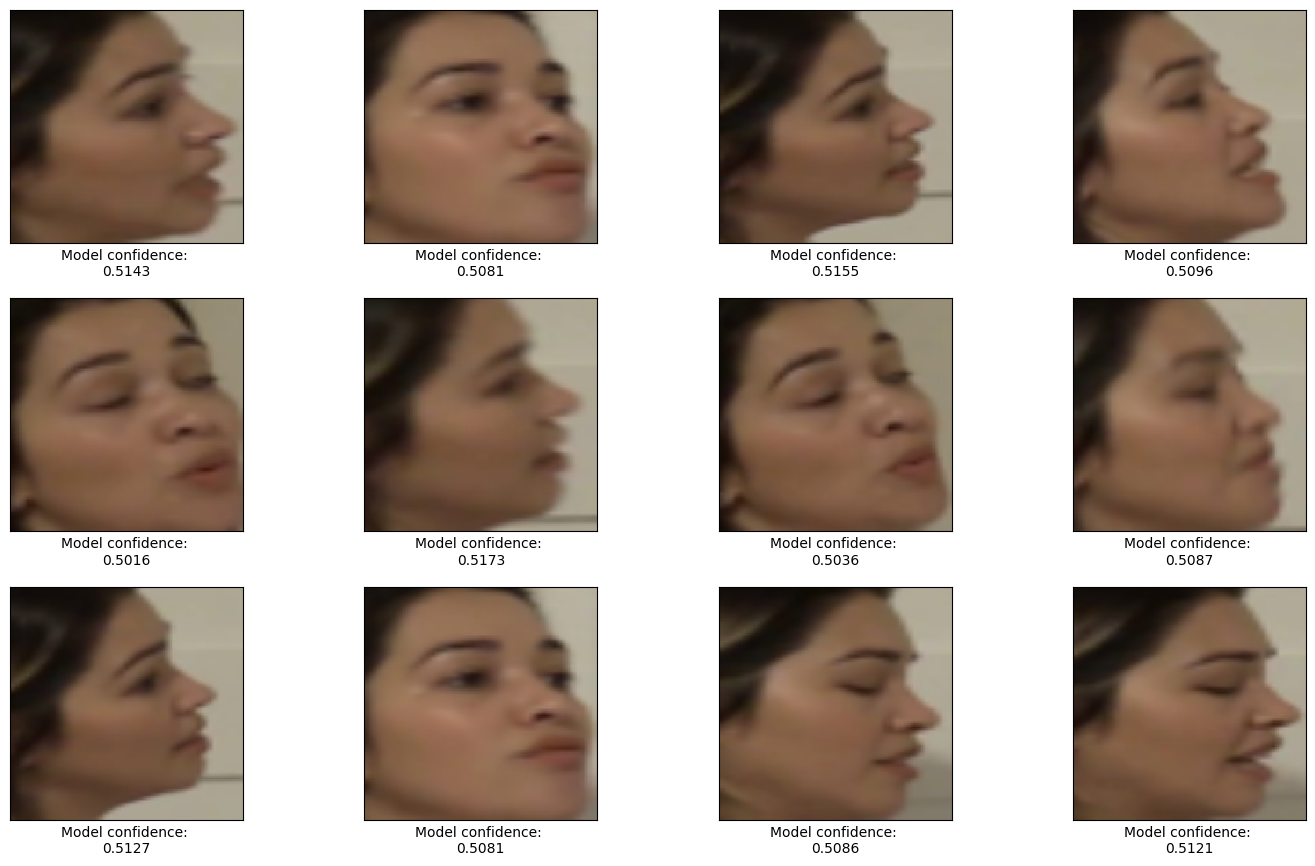

In [ ]:
plotter(correct_real, correct_real_pred)


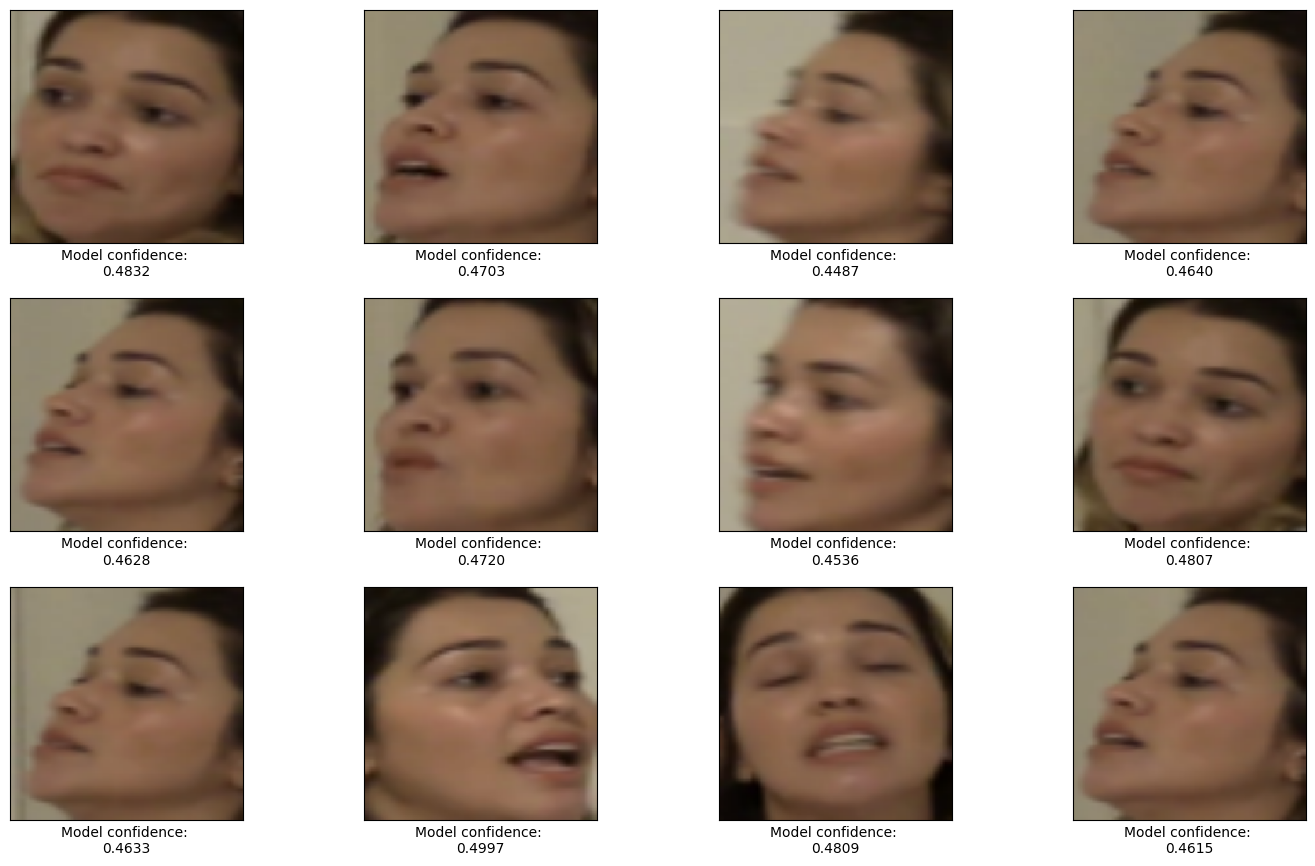

In [ ]:
plotter(misclassified_real, misclassified_real_pred)


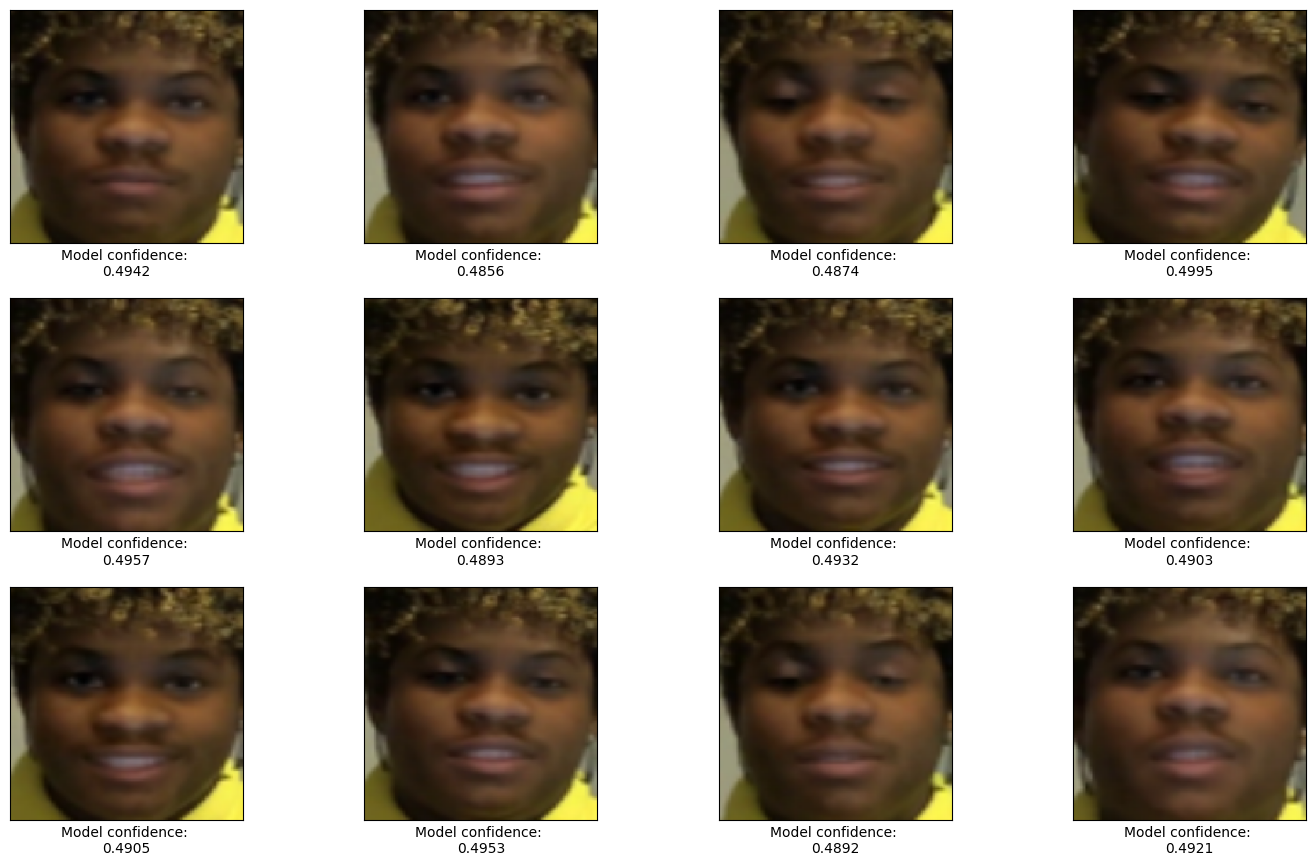

In [ ]:
plotter(correct_deepfake, correct_deepfake_pred)


In [ ]:
plotter(misclassified_deepfake, misclassified_deepfake_pred)


**END**